## Quick Start
In this notebook we will demonstrate the basic concept of RSEAP rule engine. We will work through the follwing toy business process scenario:

#### Sample scenario
A company is screening through the candidate pool for a logistic-related job position. The following are the considerations:
* Female is preferred to Male
* Owning a car driving license is preferred
* Owning a lorry driving license is preferred, only if the candidate is a local citizen (Singaporean)

The rule engine will assign appropriate score to each of the candidate.

In [1]:
# import the library
import rseap

### Preparation

In [2]:
# prepare a test case
input_msg = {
    'name': 'Alice',
    'gender': 'female',
    'driving_license': {
        'lorry': {
            'valid': False
        },
        'car': {
            'valid': True,
            'expiry_date': '2021-12-31'
        }
    },
    'logistic_experience': 3,
    'nationality': 'Singapore'
}

#### Convert the input data to an instance

Note that the user is free to choose *any* representation for an instance. Even the unmodified dictionary form will do. For demonstration purpose, here we use a Struct function to convert the dictionary to a Python object.

In [3]:
instance = rseap.utils.Struct(input_msg)

In [4]:
# demo the use of "Struct" - the nested field is converted to nested attribute
instance.driving_license.car.expiry_date

'2021-12-31'

#### Initialize a state
Again the user is free to use any python object as a state. Here again we use Struct to get a python object from a dictionary

In [5]:
state = rseap.utils.Struct({
    'license_score': 0,
    'gender_score' : 0,
})

### Create a Rule Flow

In [6]:
rule_flow = rseap.RuleFlow(
    name = 'logistic candidate scoring'
)

### Create DecisionNodes
We will have a total of 4 DecisionNodes in this example: (i) GenderScore (ii) is local? (iii) DrivingLicenseScore (iv) score aggregator.

We will demonstrate some usages of the SDK by creating them one after the other.

#### Creating GenderScore node

In [7]:
gender_node = rseap.DecisionNode(name='GenderScore')

Create the rule and add it to the node

In [8]:
# create a python function with "instance" and "state" as arguments
def func(instance, state):
    gender = getattr(instance, 'gender', None)
    if gender is None:
        return

    # if male, score is 1
    if str(gender).upper() in ['MALE', 'M']:
        state.gender_score += 1 # <- the state variable is modified here
    # end if
# end def

rule_male = rseap.DecisionRule(
    name='GenderScore-Male',
    func=func,
)

In [9]:
# add the rule to the node
gender_node.add_rule(rule_male)

In [10]:
# list the rules in a DecisionNode
gender_node.list_rules()

{'3913affd-46f3-424a-a026-a80ff3715690': {'uid': '3913affd-46f3-424a-a026-a80ff3715690',
  'rule': Rule "GenderScore-Male",
  'priority': 0}}

In [11]:
# get the rule by name
gender_node.get_rule_by_name('GenderScore-Male')

Rule "GenderScore-Male"

In [12]:
# return None if the rule is non-existent
gender_node.get_rule_by_name('non-existent rule') == None

True

Add another rule to the node

In [13]:
# create the DecisionRule
def func(instance, state):
    gender = getattr(instance, 'gender', None)
    if gender is None:
        return

    # if female, score is 2
    if str(gender).upper() in ['FEMALE', 'F']:
        state.gender_score += 2
    # end if
# end def

rule_female = rseap.DecisionRule(
    name='GenderScore-Female',
    func=func,
)

gender_node.add_rule(rule_female)

In [14]:
# add the same rule again will trigger error
gender_node.add_rule(rule_female)

AssertionError: rule with same UID has already been added

The DecisionRule content can be modified dynamically

In [15]:
# a new function
def func(instance, state):
    gender = getattr(instance, 'gender', None)
    if gender is None:
        return

    if str(gender).upper() in ['FEMALE', 'F']:
        state.gender_score += 3
    # end if
# end def

_rule = gender_node.get_rule_by_name('GenderScore-Female')
_rule.set_function(func) # set the function to a new function

In [16]:
# note the function must have "instance" and "state" input fields. Otherwise will trigger exception
def some_random_func():
    return
# end def

_rule = gender_node.get_rule_by_name('GenderScore-Female')
_rule.set_function(some_random_func)

AssertionError: function must have "instance" and "state" arguments

#### List and search rules

In [17]:
# list rules
gender_node.list_rules()

{'3913affd-46f3-424a-a026-a80ff3715690': {'uid': '3913affd-46f3-424a-a026-a80ff3715690',
  'rule': Rule "GenderScore-Male",
  'priority': 0},
 '9675cfd5-2995-45ab-bd35-b2e5aa4bebcb': {'uid': '9675cfd5-2995-45ab-bd35-b2e5aa4bebcb',
  'rule': Rule "GenderScore-Female",
  'priority': 0}}

In [18]:
# search rule by name with regex pattern
gender_node.search_rules(pattern='[mM]ale')

[Rule "GenderScore-Male", Rule "GenderScore-Female"]

### Register DecisionNode to Rule Flow

In [19]:
gender_node.register_ruleflow(rule_flow)
# or equivalently 
# rule_flow.add_node(gender_node)

In [20]:
# adding the same decision node will trigger an error
rule_flow.add_node(gender_node)

AssertionError: node with the same uid is already added in the rule flow

#### Create the second DecisionNode (nationality)

In [21]:
local_nationality_node = rseap.DecisionNode(
    name = 'Is Local?',
    ruleflow = rule_flow,
)

In [22]:
# similarly, create a rule and add function to it
rule = rseap.DecisionRule(name='is singaporean')

def func(instance, state):
    nationality = getattr(instance, 'nationality')
    
    if str(nationality) in ['SG', 'SINGAPOREAN']:
        state.is_local = True  # <- new attribute "is_local" will be added to the state
    else:
        state.is_local = False
    # end if
# end def
rule.set_function(func)

In [23]:
local_nationality_node.add_rule(rule)

In [24]:
local_nationality_node.list_rules()

{'199d83f6-466c-4725-9d5b-7899fce579a1': {'uid': '199d83f6-466c-4725-9d5b-7899fce579a1',
  'rule': Rule "is singaporean",
  'priority': 0}}

### Visualizing the RuleFlow now

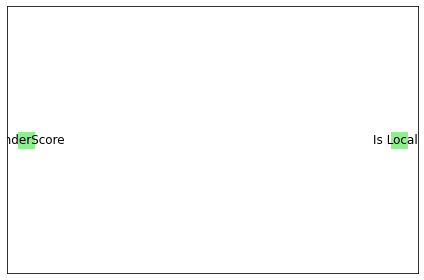

In [25]:
# two decision nodes with no connectivity now
rule_flow.visualize()

#### Create a third node (driving license)

In [26]:
driving_license_node = rseap.DecisionNode('DrivingLicenseScore')

Driving licence score has a dependency on nationality. Hence we add the nationality node as its parent

In [27]:
driving_license_node.add_parent_node(local_nationality_node)

Visualize again

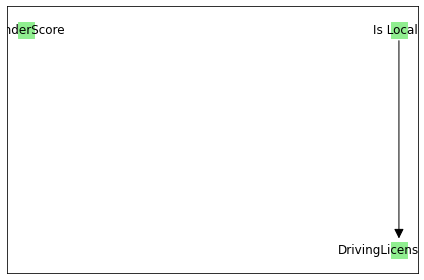

In [28]:
rule_flow.visualize()

#### Add multiple different rules to the DecisionNode

In [29]:
# The lorry driving license rule
_rule = rseap.DecisionRule('lorry_score')

# add lorry score only if the candidiate is local
def prefunc(instance, state):
    return getattr(state, 'is_local') == True
# end def

def func(instance, state):
    driving_license = getattr(instance, 'driving_license')
    if driving_license is None:
        return
    
    if driving_license.lorry.valid:
        state.license_score += 10
# end def

_rule.set_precondition(prefunc)
_rule.set_function(func)
driving_license_node.add_rule(_rule)

#### Precondition of a DecisionRule

Note that we added a "prefunc" as a precondition to the rule. The rule will activate only if the prefunc returns a True result

#### Testing rules 
Each rule can be independently tested

In [30]:
test_instance = rseap.utils.Struct({
  'name': 'Bob',
  'gender': 'male',
  'driving_license': {'lorry': {'valid': True}},
   'logistic_experience': 1,
  'nationality': 'Singapore'
})
test_state = rseap.utils.Struct({
  'is_local'     : True,
  'license_score': 0
})

In [31]:
# execute the rule on test instance and state
_rule.execute(
    instance=test_instance, 
    state=test_state
)
# print the resultant state
test_state.to_dict()

{'is_local': True, 'license_score': 10}

In [32]:
# The car driving license rule
_rule = rseap.DecisionRule('car_score')
def func(instance, state):
    driving_license = getattr(instance, 'driving_license')
    if driving_license is None:
        return
    
    if driving_license.lorry.valid:
        state.license_score += 5
# end def
_rule.set_function(func)
driving_license_node.add_rule(_rule)

Independent testing at decision node level is also supported

In [33]:
driving_license_node.process(
    instance=test_instance, 
    state=test_state
)
# print the resultant state
test_state.to_dict()

{'is_local': True, 'license_score': 25}

#### Set priority for rules
The larger the value the early in sequence the rule will be executed

In [34]:
rule_uid = driving_license_node.get_rule_by_name('lorry_score').uid
driving_license_node.set_rule_priority(rule_uid, 99)

rule_uid = driving_license_node.get_rule_by_name('car_score').uid
driving_license_node.set_rule_priority(rule_uid, 10)

In [35]:
driving_license_node.list_rules()

{'aae9caa6-6a81-480d-87e1-d02f914376cd': {'uid': 'aae9caa6-6a81-480d-87e1-d02f914376cd',
  'rule': Rule "lorry_score",
  'priority': 99},
 '58b84d5b-901f-4b90-bef7-1e4e186aac55': {'uid': '58b84d5b-901f-4b90-bef7-1e4e186aac55',
  'rule': Rule "car_score",
  'priority': 10}}

#### Creating the final DecisionNode (score aggregator)

In [36]:
score_aggregator_node = rseap.DecisionNode(name='score aggregator')

In [37]:
_rule = rseap.DecisionRule('aggregate score')
def func(instance, state):
    state.final_score = state.license_score + state.gender_score
_rule.set_function(func)
score_aggregator_node.add_rule(_rule)

Final score depends on both locality and driving license DecisionNode. We add both as parents.

In [38]:
score_aggregator_node.add_parent_node(local_nationality_node)
score_aggregator_node.add_parent_node(gender_node)

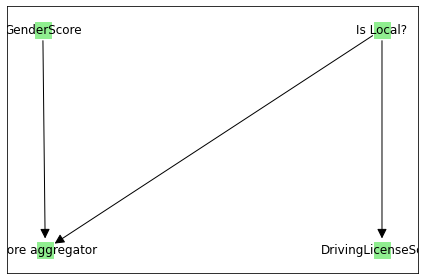

In [39]:
# visualize
rule_flow.visualize()

We made a mistake when adding the parent node. Next we demonstrate to unlink the wrong parent node (is Local?) and relink with the correct one (DrivingLicenseScore)

In [40]:
# unlink and relink with correct parent
score_aggregator_node.unlink_parent_node(local_nationality_node)
score_aggregator_node.add_parent_node(driving_license_node)

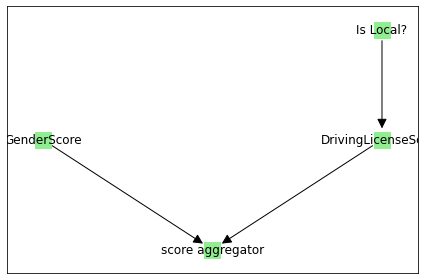

In [41]:
# visualize again
rule_flow.visualize()

### Inference

The inference step will start from the root nodes and propagate until terminal nodes

In [42]:
# show the root nodes
rule_flow.get_root_nodes()

[GenderScore, Is Local?]

In [43]:
# show the terminal nodes
rule_flow.get_terminal_nodes()

[score aggregator]

We test the RuleFlow on an instance for demonstration

In [44]:
# prepare a test case
candidate_01 = {
    'name': 'Bob',
    'gender': 'male',
    'driving_license': {
        'lorry': {
            'valid': True
        },
        'car': {
            'valid': True,
            'expiry_date': '2021-12-31'
        }
    },
    'logistic_experience': 5,
    'nationality': 'Thailand'
}

In [45]:
instance = rseap.utils.Struct(candidate_01)
state    = rseap.utils.Struct({
    'license_score': 0,
    'gender_score' : 0,
    'final_score'  : 0
})

In [46]:
# inference and get answer back
ans = rule_flow.process(
    instance = instance,
    state    = state
)

In [47]:
ans

{'status': 'success',
 'error': None,
 'tracker': <rseap.components.tracker.RuleFlowTracker at 0x7f0c9532be20>,
 'output': {'instance': <rseap.utils.Struct at 0x7f0c95300be0>,
  'state': <rseap.utils.Struct at 0x7f0c95324be0>}}

In [48]:
# print the output state
ans['output']['state'].to_dict()

{'license_score': 5, 'gender_score': 1, 'final_score': 6, 'is_local': False}

In [49]:
# print the log from the tracker
print(ans['tracker'].events_log.contents())

2021-05-09 17:51:44,956 - WARNING - More than one root node (2) was found in the rule flow
2021-05-09 17:51:44,956 - INFO - DecisionNode ready for execution: "Is Local?" [8791fcfe-7acb-4b17-b486-60724707dede]
2021-05-09 17:51:44,956 - INFO - DecisionNode executed: "Is Local?" [8791fcfe-7acb-4b17-b486-60724707dede]
2021-05-09 17:51:44,956 - INFO - DecisionNode ready for execution: "GenderScore" [cbaa9441-1f94-4ebe-af7a-029328a36174]
2021-05-09 17:51:44,956 - INFO - DecisionNode executed: "GenderScore" [cbaa9441-1f94-4ebe-af7a-029328a36174]
2021-05-09 17:51:44,956 - INFO - DecisionNode ready for execution: "DrivingLicenseScore" [18719ab6-bd07-4f91-9f4c-f4e8c51531b8]
2021-05-09 17:51:44,956 - INFO - DecisionNode executed: "DrivingLicenseScore" [18719ab6-bd07-4f91-9f4c-f4e8c51531b8]
2021-05-09 17:51:44,956 - INFO - DecisionNode ready for execution: "score aggregator" [af02696a-b2ee-4fc1-91cc-a975947eaf29]
2021-05-09 17:51:44,956 - INFO - DecisionNode executed: "score aggregator" [af02696a-